In [1]:
%load_ext autoreload
%autoreload 2
import sys
from numba import njit
from glob import glob
from natsort import natsorted
from joblib import Parallel, delayed
sys.path.insert(0, "../") 
import tifffile
from helpers import *
from scipy.optimize import curve_fit
import global_params_giant_colony as global_params

In [2]:
def load_img_mask_pair(img_dir, mask_dir, normalise = False):
    suffix = img_dir.split(".")[-1]
    if "png" in suffix:
        img = np.array(Image.open(img_dir))
    elif ("tif" or "tiff") in suffix:
        img = tifffile.imread(img_dir)
        if len(img.shape) == 3:
            img = img.sum(axis=0)
    if normalise:
        img = rescale_intensity(img, out_range=(0,1))
    mask = np.array(Image.open(mask_dir)) #Masks are always PNG
    return img, mask

@njit
def get_intensities(img, mask, mask_labels, img_2 = None):
    """
    Returns intensities of objects in the order provided by mask_labels
    """
    total_intensities = np.zeros(len(mask_labels))
    for l, mask_label in enumerate(mask_labels):
        idxs = np.where(mask == mask_label)
        if len(idxs[0]) > 100:
            pixel_intensities = np.zeros(len(idxs[0]))
            for k, (i, j) in enumerate(zip(idxs[0], idxs[1])):
                pixel_intensities[k] = img[i,j]
            total_intensity = np.sum(pixel_intensities)
            total_intensities[l] = total_intensity
    total_intensities_2 = np.zeros(len(mask_labels))

    if img_2 is not None:
        total_intensities_2 = np.zeros(len(mask_labels))
        for l, mask_label in enumerate(mask_labels):
            idxs = np.where(mask == mask_label)
            if len(idxs[0]) > 100:
                pixel_intensities = np.zeros(len(idxs[0]))
                for k, (i, j) in enumerate(zip(idxs[0], idxs[1])):
                    pixel_intensities[k] = img_2[i,j]
                total_intensity = np.sum(pixel_intensities)
                total_intensities_2[l] = total_intensity
    return total_intensities, total_intensities_2

def get_colony_diameter(mask):
    colony_regionprop = regionprops((mask > 0)*1)[0]
    return colony_regionprop.feret_diameter_max


def get_colony_centroid(mask):
    colony_regionprop = regionprops((mask > 0)*1)[0]
    #colony_centroid = colony_regionprop.centroid
    return colony_regionprop.centroid

def get_cell_pos(mask, mask_labels):
    cell_ys = np.zeros(len(mask_labels))
    cell_xs = np.zeros(len(mask_labels))
    for i, mask_label in enumerate(mask_labels):
        single_cell = (mask == mask_label) * 1
        cell_ys[i], cell_xs[i] = regionprops(single_cell)[0].centroid
    return cell_ys, cell_xs
#get_colony_size(mask)

def get_cell_n_neighbours(mask,mask_labels):
    radius = 5
    dilated = dilation(mask, skimage.morphology.disk(radius))
    rag = graph.RAG(dilated)
    rag.remove_node(0)

    n_neighbours = []
    for mask_label in mask_labels:
        n_neighbours.append(len(list(rag.neighbors(mask_label))))
    return n_neighbours

def get_cell_areas(mask, mask_labels):
    areas = np.zeros(len(mask_labels))
    for i, mask_label in enumerate(mask_labels):
        areas[i] = np.sum(mask == mask_label)
    return areas
    
#def get_dist_from_centre(mask, mask_labels):
#    dists = []
#    col_y, col_x = get_colony_centroid(mask)
#    print("Colony:", col_y, col_x)
#    for i, mask_label in enumerate(mask_labels):
#        single_cell = (mask == mask_label) * 1
#        cell_y, cell_x = regionprops(single_cell)[0].centroid
#        dist = np.sqrt( (cell_y - col_y)**2 + (cell_x - col_x)**2 )
#        print(f"Cell {mask_label}", cell_y, cell_x, dist)
#        #dists.append(dist)
#    return dists
#get_colony_size(mask)

In [147]:
real_PSF = tifffile.imread("empirical_conv_PSF.tiff")
lorentzian_PSF = tifffile.imread("../cell_distance_bleedthrough/lorentzian_PSF_515nm.tiff")

In [148]:
data = []

raw_img_dirs = natsorted(glob("data/fluorescent_scenes/*"))
synth_img_dirs = natsorted(glob(f"simulated_colonies_normal_lorentz_PSF/training_data_100x_0.515_green_1.49_1.518/synth_imgs/*"))
#assert len(synth_img_dirs) == len(raw_img_dirs)
mask_dirs = natsorted(glob("data/masks/*"))

In [149]:
raw_img, _ = load_img_mask_pair(raw_img_dirs[-1], mask_dirs[-1], normalise=False)
synth_img, mask = load_img_mask_pair(synth_img_dirs[-1], mask_dirs[-1], normalise=False)

In [150]:
from skimage.io import imread
from pyclesperanto_prototype import imshow
import RedLionfishDeconv as rl
import matplotlib.pyplot as plt
from napari_simpleitk_image_processing import richardson_lucy_deconvolution

In [151]:
#iterations = 50
#deconvolved = richardson_lucy_deconvolution(synth_img, lorentzian_PSF, iterations)
#imshow(deconvolved)

(1490, 1606)

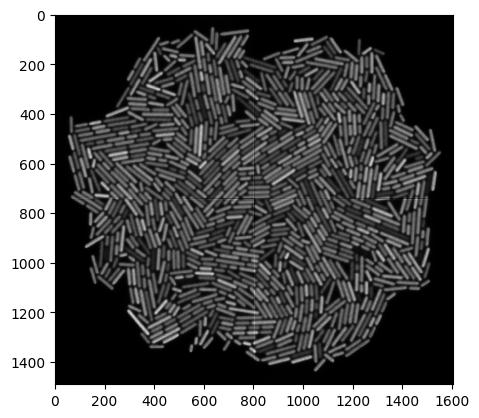

In [162]:
iterations = 50
synth_img = np.roll(synth_img,(synth_img.shape[0]//2, synth_img.shape[1]//2), axis = (0,1))
deconvolved = rl.doRLDeconvolutionFromNpArrays(synth_img.reshape(1,synth_img.shape[0],synth_img.shape[1]), 
                                               lorentzian_PSF.reshape(1,lorentzian_PSF.shape[0],lorentzian_PSF.shape[1]), 
                                               niter=iterations, 
                                               method='gpu', 
                                               resAsUint8=False)
deconvolved = deconvolved[0,:,:]
imshow(deconvolved)


In [161]:
deconvolved.shape

(1490, 1606)

In [136]:
synth_img.max()

17.453125

In [176]:
def load_and_calc_params_empirical_PSF(i, raw_img_dir, synth_img_dir, mask_dir, wavelength, NA, n, working_distance):
    raw_img, _ = load_img_mask_pair(raw_img_dir, mask_dir, normalise=False)
    synth_img, mask = load_img_mask_pair(synth_img_dir, mask_dir, normalise=False)
    mask_labels = np.unique(mask)[1:]

    pad_amount = 150
    #deconv_img = deconvolved #= richardson_lucy_deconvolution(synth_img, real_PSF, iterations)

    synth_img_for_deconv = np.roll(synth_img,(synth_img.shape[0]//2, synth_img.shape[1]//2), axis = (0,1))
    deconv_img = rl.doRLDeconvolutionFromNpArrays(synth_img_for_deconv.reshape(1,synth_img_for_deconv.shape[0],synth_img_for_deconv.shape[1]), 
                                                   lorentzian_PSF.reshape(1,lorentzian_PSF.shape[0],lorentzian_PSF.shape[1]), 
                                                   niter=iterations, 
                                                   method='gpu', 
                                                   resAsUint8=False)
    deconv_img = deconv_img[0,:,:]

    data = pd.DataFrame()

    data["Label"] = mask_labels
    data["True intensity"], data["Observed intensity"] = get_intensities(raw_img, mask, mask_labels, synth_img)
    _, data["Deconvolved intensity"] = get_intensities(raw_img, mask, mask_labels, deconv_img)

    data["Cell y"], data["Cell x"] = get_cell_pos(mask, mask_labels)
    data["Colony diameter"] = get_colony_diameter(mask)
    data["Colony centroid y"], data["Colony centroid x"] = get_colony_centroid(mask)
    data["N neighbours"] = get_cell_n_neighbours(mask, mask_labels)
    
    data["Colony N cells"] = len(mask_labels)
    data["Colony ID"] = i
    data["Wavelength"] = wavelength
    data["Area"] = get_cell_areas(mask, mask_labels)
    data["NA"] = NA
    data["ni"] = n
    return data

In [177]:
data = load_and_calc_params_empirical_PSF(0,raw_img_dirs[-2], synth_img_dirs[-2], mask_dirs[-2], 0.55, 1.49, 1.518, 170)

In [178]:
data["Distance from centre of colony"] = np.sqrt(
    (data["Cell y"] - data["Colony centroid y"])**2 + (data["Cell x"] - data["Colony centroid x"])**2 
)
data["Normalised distance from centre of colony"] = data["Distance from centre of colony"] / (data["Colony diameter"]/2)
data["Mean true intensity"] = data["True intensity"] / data["Area"]
data["Mean observed intensity"] = data["Observed intensity"] / data["Area"]
data["Mean deconvolved intensity"] = data["Deconvolved intensity"] / data["Area"]
colony_groupby = data.groupby(["Wavelength", "Colony ID", "Colony N cells", "NA", "ni"])[["Mean true intensity", "Mean observed intensity", "Mean deconvolved intensity"]]
CVs = colony_groupby.std() / colony_groupby.mean()
CVs.columns = ["True CV", "Observed CV", "Deconvolved CV"]
CVs = CVs.reset_index()
data = pd.merge(data, CVs, on=["Colony ID", "Wavelength", "Colony N cells", "NA"])
data["Observed var"] = (data["Mean observed intensity"] * data["Observed CV"]) **2 
data["Observed cell intensity / True cell intensity (mean)"] = data["Mean observed intensity"] / data["Mean true intensity"]


In [179]:
data["Deconvolved CV"].iloc[0]

0.1734862829994624

In [180]:
data["True CV"].iloc[0]

0.24761856500124024

In [181]:
data["Observed CV"].iloc[0]

0.13512109650619217